This is a sample notebook to demonstrate some of the potential of Numerai's crypto forecasting data.  
There is more we can do with it, of course, this is just a starting point.

This isn't meant to be a production piece, just sample content that can be used in reports  
or articles on the website.

If it's to be used as a stand-alone/on-demand tool, the notebook should be deconstructed  
into a more modular structure for easier expansion and integration.

In [1]:
# standard library imports
import logging
import warnings

from pathlib import Path

# suppress warnings
warnings.filterwarnings("ignore")

# configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# third-party imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import yfinance as yf

In [2]:
# constants
FIGSIZE = (6, 4)
DATA_DIR = Path('c:/Users/John/Downloads/')
OUTPUT_DIR = Path('db/crypto_mm/')

In [3]:
# configs
round_number = 808 # Numerai file round
window_size = 10 # rolling mean

In [4]:
# file paths
mm_file = DATA_DIR / f'r{round_number}_crypto_v1_0_historical_meta_models.csv'
crypto_file = OUTPUT_DIR / 'meta_model.csv'
ratings_file = OUTPUT_DIR / f'ratings/r{round_number}_ratings.csv'

In [12]:
# data processing
def load_data(filepath: Path) -> pd.DataFrame:
    """Load and preprocess the meta model data."""
    try:
        data = pd.read_csv(filepath)
        data['date'] = pd.to_datetime(data['date'])
        logging.info(f"Data loaded successfully from {filepath}")
        return data
    except FileNotFoundError:
        logging.error(f"File not found: {filepath}")
        raise

def filter_recent_tokens(data: pd.DataFrame) -> pd.DataFrame:
    """Filter the tokens to keep only those present on the most recent date."""
    most_recent_date = data['date'].max()
    recent_tokens = data[data['date'] == most_recent_date]['symbol'].unique()
    logging.info(f"Filtered tokens for {most_recent_date}")
    return data[data['symbol'].isin(recent_tokens)]

def reindex_and_fill(data):
    """Reindex the data to include all dates and fill missing values."""
    full_date_range = pd.date_range(start=data['date'].min(), end=pd.Timestamp.today(), freq='D')
    symbol_data_frames = []
    
    for symbol, group in data.groupby('symbol'):
        group = group.set_index('date').reindex(full_date_range)
        group['symbol'] = symbol
        group['mm_rescaled'] = group['mm_rescaled'].ffill()
        symbol_data_frames.append(group)
    
    complete_data = pd.concat(symbol_data_frames).reset_index()
    complete_data = complete_data.rename(columns={'index': 'date'})
    complete_data = complete_data.dropna()
    
    return complete_data

In [13]:
# analytics
def calculate_ratings(data: pd.DataFrame, window_size: int) -> pd.DataFrame:
    """Calculate the rolling average ratings."""
    data['rating'] = data.groupby('symbol')['mm_rescaled'].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    data['rating'] = data['rating'].round(2)
    data.dropna(inplace=True)
    logging.info(f"Calculated rolling average ratings with a window size of {window_size}")
    return data

def average_daily_ratings(data: pd.DataFrame) -> None:
    """Calculate and print the average rating for each day."""
    daily_average_ratings = data.groupby('date')['rating'].mean()
    daily_average_ratings = daily_average_ratings.round(2)
    logging.info("Average Ratings by Day:")

def save_data(data: pd.DataFrame, filepath: Path) -> None:
    """Save data to a CSV file."""
    data.to_csv(filepath, index=False)
    logging.info(f"Data saved to {filepath}")

def get_top_bottom_symbols(data: pd.DataFrame, date: pd.Timestamp) -> pd.DataFrame:
    """Get the top and bottom 10 symbols by rating."""
    daily_data = data[data['date'] == date][['date', 'symbol', 'rating']]
    sorted_data = daily_data.sort_values(by='rating', ascending=False)
    logging.info(f"Top and bottom symbols extracted for {date}")
    return sorted_data

In [14]:
# visualizations
def initialize_plot(title: str, xlabel: str, ylabel: str = '', figsize: tuple = FIGSIZE):
    """Initialize and customize the plot."""
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#071C2D')
    ax.set_facecolor('#071C2D')
    
    plt.title(title, fontsize=12, fontweight='bold', color='white', family='Bahnschrift')
    plt.xlabel(xlabel, color='white', family='Bahnschrift', fontsize=8, loc='right')
    
    if ylabel:
        plt.ylabel(ylabel, fontsize=8, family='Bahnschrift', color='white')
    
    ax.tick_params(axis='x', colors='white', labelsize=6, rotation=45)
    ax.tick_params(axis='y', colors='white', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.tick_params(axis='x', colors='white', width=0.25)
    ax.tick_params(axis='y', colors='white', width=0.25)
    
    return fig, ax

def plot_crypto_ranking_and_price(ticker: str, crypto_file: Path, window_size, figsize: tuple = FIGSIZE, start_date: str = '2024-05-27'):
    """Plot crypto ranking and price for a given ticker."""
    # Load and filter data for the selected ticker
    df = pd.read_csv(crypto_file)
    crypto_df = df[df['symbol'] == ticker].copy()
    crypto_df['date'] = pd.to_datetime(crypto_df['date'])
    crypto_df.sort_values('date', inplace=True)
    
    # Fetch the price data from yfinance
    price_data = yf.download(f'{ticker}-USD', start=crypto_df['date'].min(), end=None)
    price_data.reset_index(inplace=True)
    
    # Merge ranking and price data
    merged_df = pd.merge(crypto_df, price_data, left_on='date', right_on='Date', how='left')
    
    # Initialize the plot
    fig, ax1 = initialize_plot(f'{ticker} 30 Day Forecast', xlabel='@Spynsight', ylabel=f'{ticker} Price (USD)', figsize=figsize)
    
    # Plot crypto price
    ax1.plot(merged_df['date'], merged_df['Close'], color='tab:red', label=f'{ticker} Price')
    ax1.set_ylabel(f'{ticker} Price (USD)', fontsize=8, family='Bahnschrift', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='white')

    # Plot meta model ranking on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Rating', fontsize=8, family='Bahnschrift', color='tab:blue')
    ax2.plot(merged_df['date'], merged_df['rating'], color='tab:blue', marker='o', label='Smoothed Meta Model Ranking')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Customize secondary y-axis
    ax2.tick_params(axis='y', colors='white', labelsize=8)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_color('white')
    ax2.spines['bottom'].set_color('white')
    ax2.spines['left'].set_color('white')
    ax2.spines['right'].set_linewidth(0.5)
    ax2.spines['bottom'].set_linewidth(0.5)
    ax2.spines['left'].set_linewidth(0.5)
    ax2.tick_params(axis='x', colors='white', width=0.25)
    ax2.tick_params(axis='y', colors='white', width=0.25)
    
    # Set date interval and format
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Show the plot
    fig.tight_layout()
    plt.show()
    logging.info(f"Plot generated for {ticker}")


def plot_average_daily_ratings(data: pd.DataFrame, figsize: tuple = FIGSIZE) -> None:
    """Plot the average daily rating over time."""
    # Calculate the average daily ratings
    daily_average_ratings = data.groupby('date')['rating'].mean()
    
    # Initialize the plot
    fig, ax = initialize_plot("Crypto Index Outlook", xlabel="Spynsight", ylabel="Daily Rating", figsize=figsize)
    
    # Plot the data
    ax.plot(daily_average_ratings.index, daily_average_ratings.values, color='tab:blue', marker='o', label='Avg Rating')

    # Set date interval and format to show weekly ticks
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Weekly intervals
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'
    
    # Rotate and align date labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Tight layout for better spacing
    fig.tight_layout()
    
    # Show the plot
    plt.show()

    logging.info("Average Daily Rating plot generated")

In [15]:
# Load and process data
mm_data = load_data(mm_file)
mm_data = filter_recent_tokens(mm_data)

# Rescale the 'meta_model' and drop the original column
mm_data['mm_rescaled'] = mm_data['meta_model'] * 5
mm_data.drop('meta_model', axis=1, inplace=True)
    
# Reindex and fill missing data
complete_mm_data = reindex_and_fill(mm_data)

# Calculate rolling ratings
complete_mm_data = calculate_ratings(complete_mm_data, window_size)

# Save processed data
save_data(complete_mm_data, crypto_file)

2024-08-11 15:13:12,504 - INFO - Data loaded successfully from c:\Users\John\Downloads\r808_crypto_v1_0_historical_meta_models.csv


2024-08-11 15:13:12,507 - INFO - Filtered tokens for 2024-08-08 00:00:00
2024-08-11 15:13:12,869 - INFO - Calculated rolling average ratings with a window size of 10
2024-08-11 15:13:12,965 - INFO - Data saved to db\crypto_mm\meta_model.csv


In [16]:
# top and bottom symbols
today = pd.Timestamp.today().normalize()
top_bottom = get_top_bottom_symbols(complete_mm_data, today)

# Save and display top/bottom tickers
save_data(top_bottom, ratings_file)

logging.info("Top 10 Tickers by rating:")
logging.info(top_bottom['symbol'].head(10))

logging.info("Bottom 10 Tickers by rating:")
logging.info(top_bottom['symbol'].tail(10))

2024-08-11 15:13:21,447 - INFO - Top and bottom symbols extracted for 2024-08-11 00:00:00
2024-08-11 15:13:21,450 - INFO - Data saved to db\crypto_mm\ratings\r808_ratings.csv
2024-08-11 15:13:21,451 - INFO - Top 10 Tickers by rating:
2024-08-11 15:13:21,451 - INFO - 2230     ALCX
13094    DEGO
29778     OKB
23570    KP3R
47432     YFI
33755     PYR
16004     ETC
40642     SXP
11736    CTSI
7371      BNB
Name: symbol, dtype: object
2024-08-11 15:13:21,452 - INFO - Bottom 10 Tickers by rating:
2024-08-11 15:13:21,452 - INFO - 30554      ORCA
2618       ALPH
19205       GFT
31427    PEOPLE
25025    LOVELY
40933       TAO
23861       LAT
39284      STMX
42582     TURBO
27256       MOG
Name: symbol, dtype: object


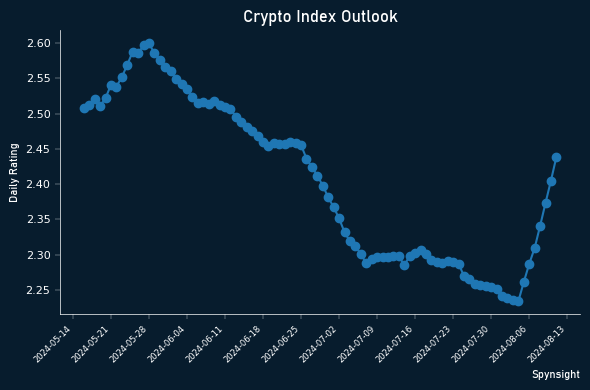

2024-08-11 15:13:24,687 - INFO - Average Daily Rating plot generated


In [17]:
# crypto index
plot_average_daily_ratings(complete_mm_data)

[*********************100%%**********************]  1 of 1 completed


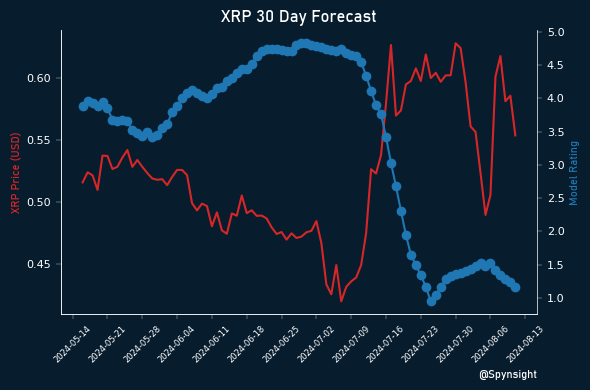

2024-08-11 15:13:30,258 - INFO - Plot generated for XRP


In [18]:
# token forecast
plot_crypto_ranking_and_price('XRP', crypto_file, window_size, figsize = FIGSIZE)